In [8]:
!pip install -U gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd /content/drive/MyDrive/datasets/ppi

/content/drive/MyDrive/datasets/ppi


In [2]:
import pandas as pd
import numpy as np


In [3]:
ls

main.ipynb  MyModel  ppi_data.txt


读取数据

In [3]:
data_path = './ppi_data.txt'
data = pd.read_csv(data_path, sep='\t', names=['head','tail','type'] )

数据探索

In [5]:
data.head()

,head,tail,type
0,KDELR2,ARF5,catalysis
1,ARF5,AP1S2,binding
2,AP1S2,ARF5,binding
3,BET1,ARF5,reaction
4,ARF5,SPTBN5,catalysis


先来观察y标签数据

In [4]:
data['type'].value_counts()

binding              319615
reaction              91341
catalysis             46337
activation            41232
compound              25070
inhibition            14797
ptmod                  9971
expression             3196
state change            110
phosphorylation          90
repression               48
ubiquitination           38
dephosphorylation         5
Name: type, dtype: int64

y有着严重的类别不均衡问题

处理类别不均衡问题可以用imblearn包将所有类处理均衡

但是也不能完全上采样均衡，这样无效数据太多，也不能完全下采样均衡这样总数据太少

抛弃imblearn包，手动下采样，上采样，维持都约等于4万条

In [9]:
binding = data[data['type']=='binding']
nums = 40000
binding_under = binding.sample(nums)
reaction = data[data['type']=='reaction']
reaction_under = reaction.sample(nums)



In [10]:
namelist = data['type'].unique()

In [14]:
res = []
res.append(binding_under)
res.append(reaction_under)
res.append(data[data['type']=='catalysis'])
res.append(data[data['type']=='activation'])
for item in namelist[4:]:
    tmp = data[data['type']==item]
    res.append(tmp.sample(nums,replace=True))


In [15]:
data_b = pd.concat(res, axis=0)


In [32]:
del data
del res

In [16]:
data_b['type'].value_counts()

catalysis            46337
activation           41232
binding              40000
reaction             40000
inhibition           40000
expression           40000
ptmod                40000
compound             40000
phosphorylation      40000
dephosphorylation    40000
repression           40000
ubiquitination       40000
state change         40000
Name: type, dtype: int64

接下来观察训练数据X

In [17]:
data_b['head'].value_counts()

CBLB       8450
PPP3CC     8168
PPP3CA     8167
PPP3R1     8084
PPP3CB     8039
           ... 
ZBTB34        1
ZNF709        1
PLEKHH3       1
ANKRD26       1
REXO4         1
Name: head, Length: 12618, dtype: int64

通过value_counts()函数可以看出来，总共有14626种不同的head，因此不能选择将其转换为onehot等稀疏向量，不然向量长度太长，过于冗余。
选择word2vec的方式，将head转换为向量，将tail转换为向量.
之后考虑到head和tail之间的先后顺序，选择将tail向量拼接在head向量后，得到一个新的向量，这个向量就是新的特征向量。

In [18]:
from gensim.models import Word2Vec
corpus = [*data_b['head'].tolist() , *data_b['tail'].tolist()]
corpus = [corpus]
w2v = Word2Vec(min_count=1,vector_size=100)
# building the vocab
w2v.build_vocab(corpus)
# training the model
w2v.train(corpus, total_examples=w2v.corpus_count, epochs=10)

(100000, 10551380)

In [19]:
w2v.save('./MyModel')

In [20]:
w2v.wv[corpus[0]]

array([[-4.7284877e-03,  1.9411300e-04, -9.7168740e-05, ...,
        -3.5157166e-03, -1.3008331e-03,  9.1054989e-03],
       [ 9.3073621e-03, -1.1870584e-03,  9.7893551e-03, ...,
         4.9539991e-03, -6.3975989e-03, -7.9428339e-03],
       [-7.8982776e-03, -2.6025348e-03,  1.1342557e-02, ...,
        -1.3911286e-02,  1.1242576e-03,  1.4909430e-03],
       ...,
       [ 8.3489111e-03, -5.7309150e-04, -9.4367787e-03, ...,
        -9.7564645e-03,  7.5821662e-03,  7.9967501e-03],
       [-7.1909428e-03,  4.2328904e-03,  2.1633934e-03, ...,
         9.4380733e-03,  7.0552849e-03,  6.7549516e-03],
       [-7.1909428e-03,  4.2328904e-03,  2.1633934e-03, ...,
         9.4380733e-03,  7.0552849e-03,  6.7549516e-03]], dtype=float32)

In [33]:
X =[]
head = data_b['head'].tolist()
tail = data_b['tail'].tolist()
for i in range(len(head)):
    x = [*w2v.wv[head[i]], *w2v.wv[tail[i]]]
    X.append(x)
X = np.array(X)
    

In [34]:
X.shape

(527569, 200)

至此，我们已经完成了训练数据X的数据预处理，将原始数据转换为向量。
接下来我们处理训练标签y。

由于类别之间不存在关联，要用对标签用one hot编码

In [59]:
from sklearn.preprocessing import Binarizer
y = data_b['type']
lb = LabelBinarizer()
# y = le.fit_transform(y)

y = lb.fit_transform(y.tolist())

In [51]:
y.shape

(527569, 13)

划分训练集和测试集

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10, random_state=42)

准备用keras搭一个简易的神经网络模型进行分类

In [53]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [54]:
vocab_size = 200
num_labels =13
#let us build a basic model
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               102912    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 13)                6

模型结构如上

接下来开始训练


In [55]:
num_epochs =10
batch_size = 128
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/10
2968/2968 - 37s - loss: 1.3017 - accuracy: 0.5190 - val_loss: 1.1230 - val_accuracy: 0.5821 - 37s/epoch - 12ms/step
Epoch 2/10
2968/2968 - 28s - loss: 1.0328 - accuracy: 0.6171 - val_loss: 0.8940 - val_accuracy: 0.6709 - 28s/epoch - 9ms/step
Epoch 3/10
2968/2968 - 45s - loss: 0.8707 - accuracy: 0.6761 - val_loss: 0.7783 - val_accuracy: 0.7106 - 45s/epoch - 15ms/step
Epoch 4/10
2968/2968 - 35s - loss: 0.7875 - accuracy: 0.7048 - val_loss: 0.7212 - val_accuracy: 0.7270 - 35s/epoch - 12ms/step
Epoch 5/10
2968/2968 - 29s - loss: 0.7371 - accuracy: 0.7224 - val_loss: 0.6793 - val_accuracy: 0.7451 - 29s/epoch - 10ms/step
Epoch 6/10
2968/2968 - 33s - loss: 0.7027 - accuracy: 0.7350 - val_loss: 0.6510 - val_accuracy: 0.7557 - 33s/epoch - 11ms/step
Epoch 7/10
2968/2968 - 29s - loss: 0.6764 - accuracy: 0.7439 - val_loss: 0.6290 - val_accuracy: 0.7629 - 29s/epoch - 10ms/step
Epoch 8/10
2968/2968 - 36s - loss: 0.6553 - accuracy: 0.7523 - val_loss: 0.6148 - val_accuracy: 0.7668 - 36s/epo

训练完毕，测试一下acc

In [56]:
score, acc = model.evaluate(X_test, y_test,batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

413/413 - 1s - loss: 0.5862 - accuracy: 0.7769 - 1s/epoch - 3ms/step
Test accuracy: 0.7768637537956238


画一下混淆矩阵看一看预测错误预测成功的比例

Normalized confusion matrix


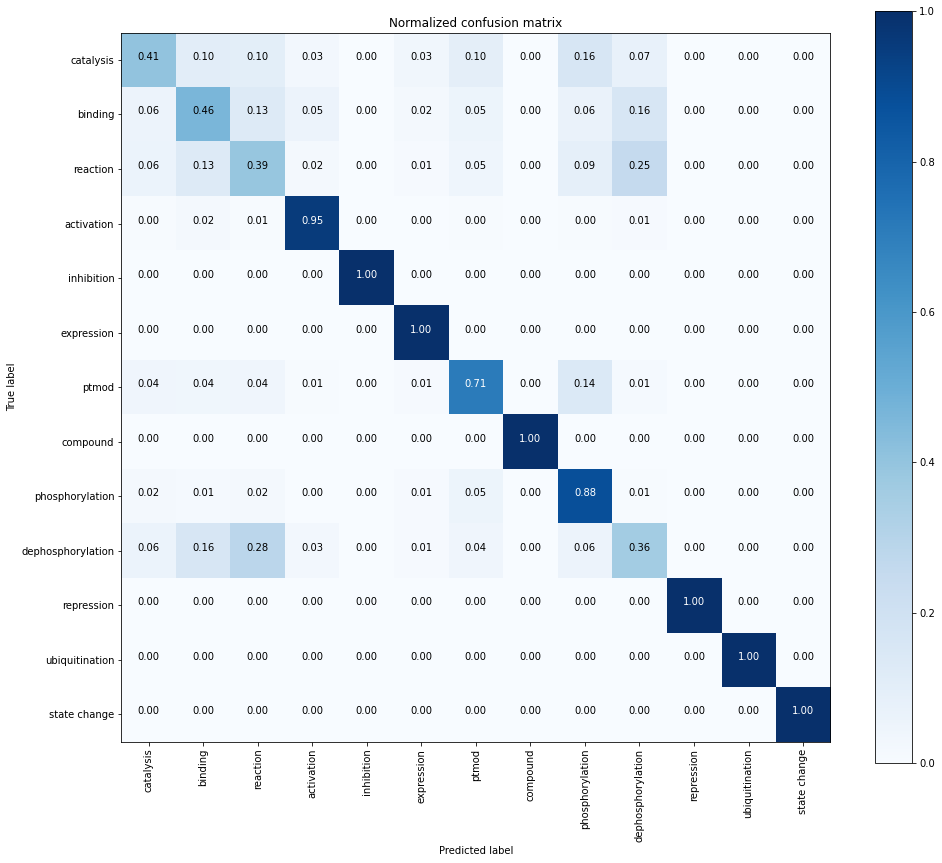

In [58]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(namelist), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)

把测试集前十个样本预测一下，对比真实的分类，看看效果

In [60]:
text_labels = lb.classes_

for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    actual_label = text_labels[np.argmax(y_test[i])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + actual_label)
    print("Predicted label: " + predicted_label)

Actual label:binding
Predicted label: binding
Actual label:inhibition
Predicted label: inhibition
Actual label:phosphorylation
Predicted label: phosphorylation
Actual label:compound
Predicted label: compound
Actual label:phosphorylation
Predicted label: phosphorylation
Actual label:inhibition
Predicted label: inhibition
Actual label:compound
Predicted label: compound
Actual label:inhibition
Predicted label: inhibition
Actual label:state change
Predicted label: state change
Actual label:catalysis
Predicted label: catalysis


In [61]:
prediction = model.predict(X_test)
predictions = np.argmax(prediction, axis = 1)

In [62]:
predictions

array([ 1,  6,  7, ..., 11, 11, 11])

In [63]:
y_test_labels = np.argmax(y_test, axis =1)

In [64]:
y_test_labels

array([ 1,  6,  7, ..., 11, 11, 11])

In [65]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([11,  6,  4, ...,  7,  0,  2])

算一下通用的分类metrics

In [66]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test_labels, predictions)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.62504673 0.48353372 0.43938656 0.87232081 1.         0.91506229
 0.69905801 0.99729331 0.62263815 0.3932306  0.99924471 0.9987718
 0.99851006]
recall: [0.40621963 0.4623844  0.39222077 0.95364072 1.         0.99753086
 0.70925553 1.         0.88051424 0.35859473 1.         1.
 1.        ]
fscore: [0.49241643 0.47272263 0.41446613 0.91116996 1.         0.95451861
 0.70411985 0.99864482 0.72945599 0.37511484 0.99962221 0.99938552
 0.99925447]
support: [4116 4001 4602 3969 3982 4050 3976 4053 3967 3985 3969 4066 4021]


● What’s your prediction outcome variable?

    因为我使用了onehot编码，总共有13类，所以输出就是一个长度13的向量，值是1的index代表属于哪一类。

● How’s the training cohort constructed?

    训练数据分为训练集测试集，shuffle后输入神经网络模型
    

● What are the features used and how are they constructed?

    我将head蛋白质和tail蛋白质从名字映射到size为100的向量。考虑到head和tail的前后关系，我选择将tail向量拼接在head向量后变成size为200的向量。作为训练数据。

● How do you evaluate the model?

    通过一些通用分类指标，precision，roc，auc，f1_score，还用了混淆矩阵

● What would be the next steps?

    首先由于时间限制，我最后一天才开始做。没有花更多的时间去训练这个神经网络，只训练了10个epoch，没有可视化loss曲线，没有调参并没有确定是否收敛，是否已经达到最高的精准度了。
    
    其次只用了一个小的神经网络。还有没有和其他机器学习模型比如xgb，逻辑回归，svm等做对比